In [1]:
%matplotlib inline
import os
from tqdm import tqdm
import sys
import os
file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(os.path.dirname(file_path)))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)
    
import time
import jax
from jax import lax
from jax import flatten_util
from Crunch.Models.layers import  *
from Crunch.Models.polynomials import  *
from Crunch.Auxiliary.metrics import  *
from jax import vmap
import jax.numpy as jnp
import jaxopt
import argparse
import optax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange
from jax import jvp, vjp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial
import scipy
from pyDOE import lhs
import scipy.io as sio

import jax
import jax.numpy as jnp
import random


Project root: /oscar/data/gk/jdtoscan/References/KKANs/Kurkova-Kolmogorov-Arnold-Newtorks-KKANs


In [2]:
from jax import config
config.update("jax_default_matmul_precision", "float32")
# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [3]:
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

4


In [4]:
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--Equation', type=str, default='Mark_GC', help='Name of equation')
parser.add_argument('--Name', type=str, default='cKAN', help='Name of the experiment')
parser.add_argument('--NC', type=int, default=32768, help='Number of samples for training')
parser.add_argument('--NI', type=int, default=512, help='Number of iterations')
parser.add_argument('--NB', type=int, default=512, help='Batch size')
parser.add_argument('--NC_TEST', type=int, default=100, help='Number of test samples')
parser.add_argument('--SEED', type=int, default=111, help='Random seed')
parser.add_argument('--EPOCHS', type=int, default=200000, help='Number of training epochs')
parser.add_argument('--N_LAYERS', type=int, default=4, help='Number of layers in the network')
parser.add_argument('--HIDDEN', type=int, default=50, help='Number of hidden units per layer')
parser.add_argument('--FEATURES', type=int, default=1, help='Feature size')
parser.add_argument('--degree', type=int, default=5, help='Degree of outer')
parser.add_argument('--degree_T', type=int, default=5, help='Degree of polynomial')
parser.add_argument('--lr_fact', type=float, default=0.2, help='Scale Lr')
parser.add_argument('--eta', type=float, default=0.01, help='Learning rate or step size for adaptive gamma')
parser.add_argument('--gamma', type=float, default=0.999, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_grads', type=float, default=0.99, help='Decay rate for adaptive gamma')
parser.add_argument('--alpha', type=float, default=0.999750, help='Decay rate for exponential moving average')
parser.add_argument('--cap_RBA', type=float, default=20, help='Cap limit for RBA')
parser.add_argument('--max_RBA', type=float, help='Maximum RBA value, default calculated as eta / (1 - gamma)')
parser.add_argument('--decay_rate', type=float, default=0.9, help='Decay rate for learning rate schedule')
parser.add_argument('--LR', type=float, default=1e-3, help='Initial learning rate')
parser.add_argument('--decay_step', type=int,default=5000, help='Decay step size')
parser.add_argument('--Note', type=str, default='', help='In case')
parser.add_argument('--basis', type=str, default='sin_series', help='basis selection for g')


# Parse arguments and display them
args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

# Initialize parameters with parsed or default values
NC = args.NC
NI = args.NI
NB = args.NB
NC_TEST = args.NC_TEST
SEED = args.SEED
EPOCHS = args.EPOCHS
N_LAYERS = args.N_LAYERS
HIDDEN = args.HIDDEN
FEATURES = args.FEATURES
degree = args.degree
degree_T = args.degree_T
eta = args.eta
#RBA Params
gamma = args.gamma
alpha = args.alpha
max_RBA0 = args.max_RBA if args.max_RBA is not None else eta / (1 - gamma)
cap_RBA = args.cap_RBA
# Global weights
gamma_grads=args.gamma_grads
# Optimizer parameters
decay_rate = args.decay_rate
LR = args.LR
lr0 = LR
decay_step = args.decay_step# if args.decay_step is not None else int(EPOCHS * jnp.log(decay_rate) / jnp.log(lrf / lr0))
args.Name=args.Name+f'NC:{NC}'+args.Note
print(args.Name)
# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
# Initialize NumPy seed
np.random.seed(SEED)
# Initialize Python's random module seed
random.seed(SEED)


Equation: Mark_GC
Name: cKAN
NC: 32768
NI: 512
NB: 512
NC_TEST: 100
SEED: 111
EPOCHS: 200000
N_LAYERS: 4
HIDDEN: 50
FEATURES: 1
degree: 5
degree_T: 5
lr_fact: 0.2
eta: 0.01
gamma: 0.999
gamma_grads: 0.99
alpha: 0.99975
cap_RBA: 20
max_RBA: None
decay_rate: 0.9
LR: 0.001
decay_step: 5000
Note: 
basis: sin_series
cKANNC:32768


## 1. PINN

In [5]:
class PINN(nn.Module):
    degree: int
    degree_T: int
    features: Sequence[int]
    M: int = 10
    g_type: str= 'rbf'
    out_dim: int =1   
    @nn.compact
    def __call__(self, t, x):
        init = nn.initializers.glorot_normal()
        X = jnp.concatenate([t, x], axis=-1)
        for fs in self.features:
            X= Cheby_KAN_layer(out_dim=fs, degree=self.degree)(X)
        return X


In [6]:
@partial(jax.jit, static_argnums=(0, 1))  # key and optimizer are static
def update_model(key, optimizer, gradient, params, state):
    # Perform updates using the specified optimizer and key
    updates, new_state = optimizer.update(gradient['params'][key], state)
    new_params = optax.apply_updates(params['params'][key], updates)
    # Return updated parameters and state for this key only
    params['params'][key] = new_params
    return params, new_state


In [7]:
@partial(jax.jit, static_argnums=(0,))
def apply_model(apply_fn, params, lambdas, gamma, eta,lamE,lamB,all_grads,alpha, *train_data):
    # Unpack data
    def data_loss(params, t, x, u,lambdas):
        return jnp.mean(lambdas*(apply_fn(params, t, x) - u)**2)
    # unpack data
    ti,xi,ui = train_data
    #Update RBA
    r_i=jnp.abs((apply_fn(params, ti, xi) - ui))
    new_lambdas=gamma*lambdas+eta*(r_i/r_i.max())
    #Function
    loss_fn = lambda params: data_loss(params, ti,xi,ui,new_lambdas)
    loss, total_gradient = jax.value_and_grad(loss_fn)(params)

    #Store
    all_loss={
        'loss_data':loss,
        'loss_BCs':0.0,
        'Loss':loss,
    }
    all_grads={
        'grad_bar_PDE':0.0,
        'grad_bar_BCs':0.0,
        'grad_PDE':0.0,
        'grad_BCs':0.0,
    }
    return all_loss, total_gradient, new_lambdas,lamB,all_grads

In [8]:
def get_gamma(eta, max_RBA):
    gamma_it = 1-eta/max_RBA
    return gamma_it

# Generate Data

In [9]:
def Oscillatory_MA_1D(x):
    return np.sin(x)+(1/3)*np.sin(3*np.pi*x)+(1/5)*np.sin(5*np.pi*x)+(1/7)*np.sin(7*np.pi*x)


In [10]:
# Generate the full domain grid
x1_vals = np.linspace(-1, 1, 256)
x2_vals = np.linspace(-1, 1, 256)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
T, X = X1, X2

t = T.flatten()[:, None]
x = X.flatten()[:, None]
Exact0 = Oscillatory_MA_1D(X)*Oscillatory_MA_1D(T)
u_gt = Exact0.flatten()[:, None]

# Collocation points for training data using LHS
lb = jnp.array([X1.min(), X2.min()])
ub = jnp.array([X1.max(), X2.max()])
X_c = lb + (ub - lb)*lhs(2, NC)
tc = X_c[:, 0:1]
xc = X_c[:, 1:2]

u_train = Oscillatory_MA_1D(xc)*Oscillatory_MA_1D(tc)

# Create train dataset
train_data = tc, xc, u_train
lambdas=u_train*0+0.1

# Create test dataset using the full ground truth
test_data = t, x, u_gt


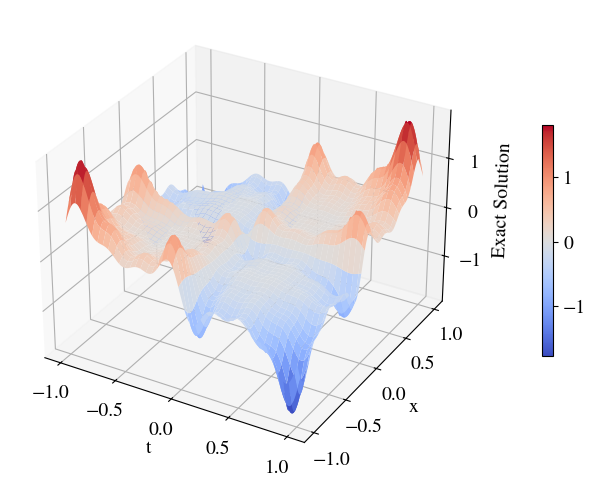

In [11]:
# Create a new figure with 3D projection
fig = plt.figure(figsize=(9, 6))

# Single 3D Surface plot for Exact solution
ax = fig.add_subplot(111, projection='3d')  # Single plot
surf = ax.plot_surface(T, X, Exact0, cmap='coolwarm')  # Surface plot
fig.colorbar(surf, ax=ax, shrink=0.5, pad=0.1)  # Add color bar and shrink it

# Set labels and title
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('Exact Solution')

# Show plot
plt.show()


## Initialize Model

In [12]:
# feature sizes
feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(degree,degree_T,feat_sizes)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)))

optimizers = {}
for key in params['params'].keys():
    if key=='g_fx':
        print(f'Kart model with basis:{args.basis}')
        optimizers[key]=optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False))
    else:
        optimizers[key]=optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False))

# Initialize optimizer states for each parameter group
states = {key: optim.init(params['params'][key]) for key, optim in optimizers.items()}

# forward & loss function
apply_fn = jax.jit(model.apply)


total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

(50, 50, 50, 50, 1)
45900


In [13]:
def get_g_x(params, t, x):
    # Compute u
    u = apply_fn(params, t, x)
    # Compute derivatives
    v_t = jnp.ones_like(t)
    v_x = jnp.ones_like(x)
    u_t = jvp(lambda t_val: apply_fn(params, t_val, x), (t,), (v_t,))[1]
    u_x = jvp(lambda x_val: apply_fn(params, t, x_val), (x,), (v_x,))[1]
    return jnp.hstack([u_t,u_x])
def get_GC(params,t,x):
    g_x=get_g_x(params, t, x)[:,:,None]
    norm_f_tx = jnp.linalg.norm(g_x, ord='fro', axis=(1, 2))**2
    model_gc=jnp.mean(norm_f_tx)
    return model_gc
print(get_GC(params,t,x))



4.218844e-08


In [14]:
all_errors = []
all_errors_train = []

all_its = []
all_loss = []
all_gamma = []
all_lamB = []
all_max_RBA = []

all_lamE = []
all_lambdas=[]
all_gc = []

start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')
gamma_it=get_gamma(eta, max_RBA0)
#Global weights
max_RBA=max_RBA0
lamE,lamB=1,max_RBA**2
#RBA
step_RBA=(cap_RBA-max_RBA0)/((EPOCHS)/50000-1)
# initialize grads container
all_grads={
    'grad_bar_PDE':1,
    'grad_bar_BCs':1,
}
for e in pbar:
    # single run
    all_loss_it, gradient, lambdas,lamB,all_grads = apply_model(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB,all_grads,alpha, *train_data)
    for key in params['params']:
        params, states[key] = update_model(key, optimizers[key], gradient, params, states[key])
    log_frequency = 1 if e < 500 else 100 if e <= 5000 else 500
    if e % log_frequency == 0:
        # Update RBA
        max_RBA=max_RBA0+step_RBA*e//50000
        if max_RBA>cap_RBA+1:
            max_RBA=cap_RBA+1
            alpha=1
        gamma_it=get_gamma(eta, max_RBA)
        all_lambdas.append(np.array(lambdas))  # JAX to NumPy conversion
        #Compute errors
        error = relative_l2(apply_fn(params, t, x), u_gt)
        error_train=relative_l2(apply_fn(params, tc, xc), u_train)
        # Geometric Complexity
        model_gc=get_GC(params,t,x)
        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"It: {e}/{EPOCHS} | Training Error: {error_train:.3e} |Error: {error:.3e} | lam_max: {lambdas.max():.3f}| max_RBA: {max_RBA:.3f}| lamB: {lamB:.3f}|")      
        # Append metrics to lists
        all_errors.append(error)
        all_errors_train.append(error_train)
        all_its.append(e)
        all_lambdas.append(np.array(lambdas))
        all_loss.append(all_loss_it['Loss'])
        all_gamma.append(gamma_it)
        all_lamB.append(lamB)
        all_max_RBA.append(max_RBA)
        all_lamE.append(lamE)
        all_gc.append(model_gc)
end = time.time()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')

Training Progress:   0%|          | 0/200000 [00:00<?, ?it/s]

It: 200000/200000 | Training Error: 2.820e-04 |Error: 3.050e-04 | lam_max: 18.703| max_RBA: 21.000| lamB: 100.000|: 100%|██████████| 200000/200000 [14:29<00:00, 230.11it/s]

Runtime: 4.35 ms/iter.


# Save Results

In [15]:
results_dict = {
    'model_name': args.Name,
    'all_errors': all_errors,
    'all_errors_train':all_errors_train,
    'all_its': all_its,
    'all_loss': all_loss,
    'all_gamma': all_gamma,
    'all_lamB': all_lamB,
    'all_max_RBA': all_max_RBA,
    'all_gc': all_gc,
}

# Save dictionary as a .mat file
scipy.io.savemat(args.Name + 'Log_files.mat', results_dict)

# Errors


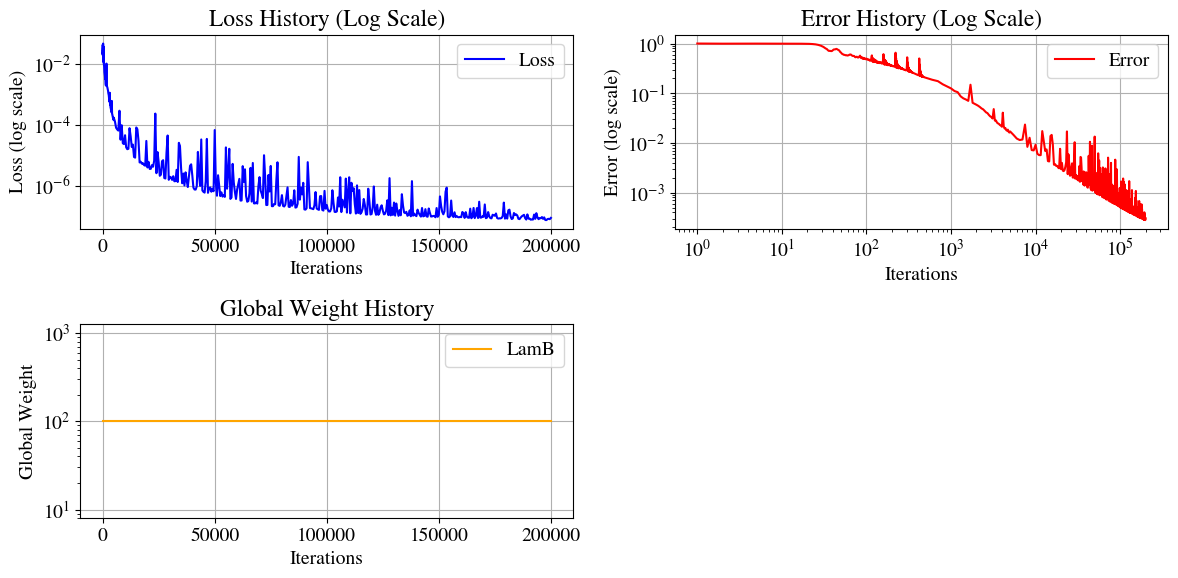

In [16]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(12, 6))

# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_loss, label='Loss', color='blue')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.title('Loss History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 2)
plt.plot(all_its, all_errors, label='Error', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 3)
plt.plot(all_its, all_lamB, label='LamB', color='orange')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Global Weight')
plt.title('Global Weight History')
plt.grid(True)
plt.legend()



# Show the plots
plt.tight_layout()
plt.savefig(args.Name+'_Loss.png')
plt.show()


In [17]:
error = relative_l2(apply_fn(params, t, x), u_gt)
print(f'RL2 error: {error:.8f}') 

RL2 error: 0.00030502


Solution:


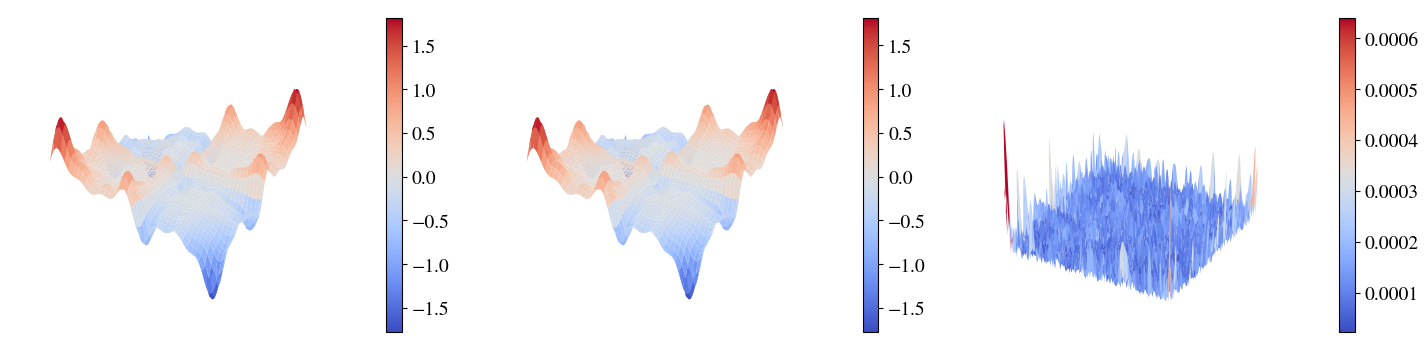

In [18]:
print('Solution:')
u = apply_fn(params, t, x)
u = u.reshape(T.shape)

# Create figure for 3D surface plots
fig = plt.figure(figsize=(15, 6))
levels = 50

# Surface plot for Prediction
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(T, X, u, cmap='coolwarm')
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, pad=0.1)  # Add color bar

# Remove axis lines, ticks, and labels
ax1._axis3don = False
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')
ax1.set_title('')

# Surface plot for Exact solution
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(T, X, Exact0, cmap='coolwarm')
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.6, pad=0.1)  # Add color bar

# Remove axis lines, ticks, and labels
ax2._axis3don = False
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_zlabel('')
ax2.set_title('')

# Surface plot for Error
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(T, X, np.abs(Exact0 - u), cmap='coolwarm')
cbar3 = fig.colorbar(surf3, ax=ax3, shrink=0.6, pad=0.1)  # Add color bar

# Remove axis lines, ticks, and labels
ax3._axis3don = False
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_zlabel('')
ax3.set_title('')

# Adjust layout
plt.tight_layout(pad=2)
plt.savefig(args.Name+'_Results_3D.png', dpi=300)
plt.show()
